## 天猫复购预测模型

#### 问题背景描述
商家有时会在特定日期，例如Boxing-day，黑色星期五或是双十一（11月11日）开展大型促销活动或者发放优惠券以吸引消费者，然而很多被吸引来的买家都是一次性消费者，这些促销活动可能对销售业绩的增长并没有长远帮助，因此为解决这个问题，商家需要识别出哪类消费者可以转化为重复购买者。通过对这些潜在的忠诚客户进行定位，商家可以大大降低促销成本，提高投资回报率（Return on Investment, ROI）。众所周知的是，在线投放广告时精准定位客户是件比较难的事情，尤其是针对新消费者的定位。不过，利用天猫长期积累的用户行为日志，我们或许可以解决这个问题。

我们提供了一些商家信息，以及在“双十一”期间购买了对应产品的新消费者信息。你的任务是预测给定的商家中，哪些新消费者在未来会成为忠实客户，即需要预测这些新消费者在6个月内再次购买的概率。

#### 数据说明
数据集包含了匿名用户在 "双十一 "前6个月和"双十一 "当天的购物记录，标签为是否是重复购买者。出于隐私保护，数据采样存在部分偏差，该数据集的统计结果会与天猫的实际情况有一定的偏差，但不影响解决方案的适用性。训练集和测试集数据见文件data_format2.zip，数据详情见下表。

| 字段名称     | 描述                                                    |
| ------------ | ------------------------------------------------------------ |
| user_id      | 购物者的唯一ID编码                                           |
| age_range    | 用户年龄范围。                                               |
| gender       | 用户性别。0表示女性，1表示男性，2和NULL表示未知              |
| merchant_id  | 商家的唯一ID编码                                             |
| label        | 取值集合为{0, 1, -1, NULL}。取1表示'userid'是'merchantid'的重复买家，取0则反之。取-1表示'user_id'不是给定商家的新客户，因此不在我们预测范围内，但这些记录可能会提供额外信息。测试集这一部分需要预测，因此为NULL。 |
| activity_log | {userid, merchantid}之间的每组交易中都记录有itemid, categoryid, brand_id, time，用#分隔。记录不按任何特定顺序排序。 |


我们还以另一种格式提供了相同数据集，可能更方便做特征工程，详情见data_format1.zip文件夹（内含4个文件），数据描述如下。

- **用户行为日志** user_log_format1.csv

| 字段名称    | 描述                                                     |
| ----------- | ------------------------------------------------------ |
| user_id     | 购物者的唯一ID编码                                       |
| item_id     | 商品的唯一编码                                           |
| cat_id      | 商品所属品类的唯一编码                                    |
| merchant_id | 商家的唯一ID编码                                          |
| brand_id    | 商品品牌的唯一编码                                        |
| time_tamp   | 购买时间（格式：mmdd）                                    |
| action_type | 包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹 |

- **用户画像** user_info_format1.csv

| 字段名称  | 描述                                            |
| --------- | ----------------------------------------------- |
| user_id   | 购物者的唯一ID编码                              |
| age_range | 用户年龄范围。                                  |
| gender    | 用户性别。0表示女性，1表示男性，2和NULL表示未知 |

- **训练数据和测试数据** train_format1.csv & test_format1.csv

| 字段名称    | 描述                                                     |
| ----------- | ------------------------------------------------------ |
| user_id     | 购物者的唯一ID编码                                       |
| merchant_id | 商家的唯一ID编码                                         |
| label      | 包含{0, 1}，1表示重复买家，0表示非重复买家。测试集这一部分需要预测，因此为空。 |

#### 数据来源
天池：https://tianchi.aliyun.com/competition/entrance/231576/information

#### 目录
- 数据清洗
- 特征构建
- 模型训练
- 模型预测

### 1、数据清洗

In [62]:
# 导入包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 显示设置
pd.set_option('display.max_columns', 30)
plt.rcParams.update({"font.family":"SimHei","font.size":14})
plt.style.use("tableau-colorblind10")
%matplotlib inline

In [2]:
# 加载数据
data_user_info = pd.read_csv('./data/user_info_format1.csv')
data_train = pd.read_csv('./data/train_format1.csv')
data_test = pd.read_csv('./data/test_format1.csv')
# 二次导入数据时，指定数据类型以压缩内存
d_types = {'user_id': 'int32', 'item_id': 'int32', 'cat_id': 'int16', 'seller_id': 'int16', 'brand_id': 'float32', 'time_stamp': 'int16', 'action_type': 'int8'}
data_user_log = pd.read_csv('./data/user_log_format1.csv', dtype=d_types)

In [3]:
# 检查表数据
display(data_user_log.head(1))
display(data_user_info.head(1))
display(data_train.head(1))
display(data_test.head(1))

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0


,user_id,age_range,gender
0,376517,6.0,1.0


,user_id,merchant_id,label
0,34176,3906,0


,user_id,merchant_id,prob
0,163968,4605,NaN


#### 1.1 数据类型检查

In [4]:
# 检查表信息
display(data_user_log.info())
display(data_user_info.info())
display(data_train.info())
display(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int32  
 1   item_id      int32  
 2   cat_id       int16  
 3   seller_id    int16  
 4   brand_id     float32
 5   time_stamp   int16  
 6   action_type  int8   
dtypes: float32(1), int16(3), int32(2), int8(1)
memory usage: 995.2 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261477 entries, 0 to 261476
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      261477 non-null  int64  
 1   merchant_id  261477 non-null  int64  
 2   prob         0 non-null       float64
dtypes: float64(1), int64(2)
memory usage: 6.0 MB


None

训练集和测试集都有约26万条数据。

#### 1.2 压缩数据

In [5]:
# 拼接train、test数据，方便下一步提取特征
data_train['origin'] = 'train'
data_test['origin'] = 'test'
data = pd.concat([data_train, data_test], sort=False)
data = data.drop(['prob'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 261476
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      522341 non-null  int64  
 1   merchant_id  522341 non-null  int64  
 2   label        260864 non-null  float64
 3   origin       522341 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 19.9+ MB


In [11]:
# list1 = [data, data_user_log, data_user_info]

list1 = [data, data_user_info]
for df in list1:
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

In [12]:
# 再次检查表信息
display(data_user_log.info())
display(data_user_info.info())
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int32  
 1   item_id      int32  
 2   cat_id       int16  
 3   seller_id    int16  
 4   brand_id     float32
 5   time_stamp   int16  
 6   action_type  int8   
dtypes: float32(1), int16(3), int32(2), int8(1)
memory usage: 995.2 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int32  
 1   age_range  421953 non-null  float32
 2   gender     417734 non-null  float32
dtypes: float32(2), int32(1)
memory usage: 4.9 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 261476
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      522341 non-null  int32  
 1   merchant_id  522341 non-null  int16  
 2   label        260864 non-null  float32
 3   origin       522341 non-null  object 
dtypes: float32(1), int16(1), int32(1), object(1)
memory usage: 13.0+ MB


None

In [13]:
# 记录数据类型
d_col = data_user_log.dtypes.index
d_type = [i.name for i in data_user_log.dtypes.values]
column_dict = dict(zip(d_col,d_type))
print(column_dict)

{'user_id': 'int32', 'item_id': 'int32', 'cat_id': 'int16', 'seller_id': 'int16', 'brand_id': 'float32', 'time_stamp': 'int16', 'action_type': 'int8'}


In [14]:
# 统一字段名
data_user_log.rename(columns = {"seller_id":"merchant_id"},inplace = True)

#### 1.3 空值处理

In [15]:
# 年龄、性别列存在null值，填补空值
data_user_info['age_range'].fillna(0, inplace=True)
data_user_info['gender'].fillna(2, inplace=True)
data_user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int32  
 1   age_range  424170 non-null  float32
 2   gender     424170 non-null  float32
dtypes: float32(2), int32(1)
memory usage: 4.9 MB


In [16]:
# 检查user_log空值
data_user_log.isna().sum()

user_id            0
item_id            0
cat_id             0
merchant_id        0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

In [17]:
# brand_id 列有较多空值，以0填充
data_user_log['brand_id'].fillna(0, inplace=True)

#### 1.4 数据初步可视化

<AxesSubplot: >

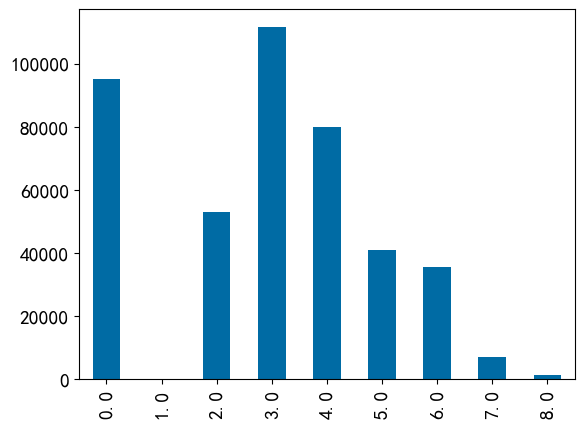

In [18]:
# 用户年龄分布
tags = data_user_info.age_range.value_counts().sort_index()
tags.plot.bar()

<AxesSubplot: >

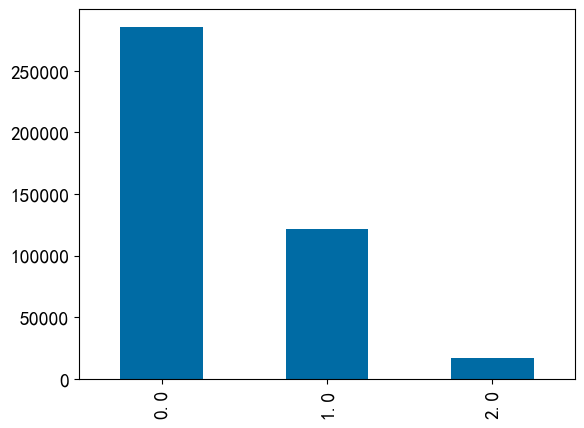

In [19]:
# 用户性别分布
tags = data_user_info.gender.value_counts().sort_index()
tags.plot.bar()

用户年龄1表示<18岁，2表示18-24岁，3表示25-29岁，4表示30-34岁，5表示35-39岁，6表示40-49岁，7、8表示50岁以上，0表示未知。

性别0表示女性，1表示男性，2表示未知。

可以看出用户主要集中在25-29岁，女性较多。

出于隐私保护，数据采样存在部分偏差，结果并不代表天猫实际情况。

<AxesSubplot: >

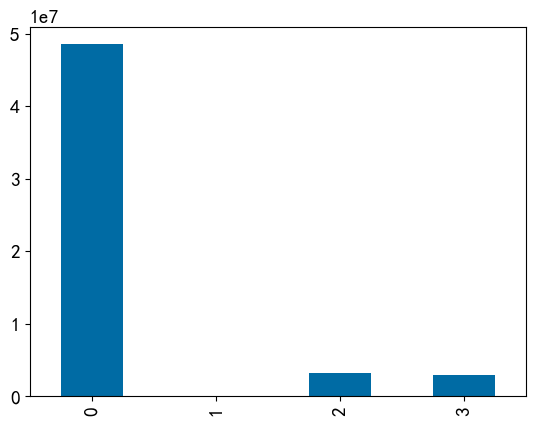

In [20]:
# 用户操作类型分布
tags = data_user_log.action_type.value_counts().sort_index()
tags.plot.bar()

操作类型中0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹。

大部分用户都只是进行点击操作，添加购物车的比较少，多为直接购买或添加收藏夹。

### 2、构建特征

从业务上思考可能影响复购的因素有哪些：
- 用户特征：年龄、性别，喜好的产品类型，购买习惯（网购频率、网购点击比等），喜欢尝鲜还是习惯固定店家购买
- 商家特征：产品结构、流量（用户交互频次、交互天数）、口碑（购买点击比）、产品评价（用户复购率）
- 用户-商家特征：用户喜好与商家产品的相似性

因此我们针对用户、商家、用户-商家来分别构建以下特征：
- 交互次数、交互天数
- 交互过的商品、品类、品牌、用户/商家数
- 点击、加购物车、购买、收藏的操作次数
- 购买点击比
- 复购率
- 用户性别、年龄

#### 2.1 用户特征


In [21]:
# 按user_id分组
groups = data_user_log.groupby(['user_id'])

In [29]:
# 统计交互
temp = groups.size().reset_index().rename(columns={0:'u1'})
data = pd.merge(data, temp, on='user_id', how='left')
data.head()

,user_id,merchant_id,label,origin,u1
0,34176,3906,0.0,train,451
1,34176,121,0.0,train,451
2,34176,4356,1.0,train,451
3,34176,2217,0.0,train,451
4,230784,4818,0.0,train,54


In [30]:
# 统计交互天数
temp = groups.time_stamp.nunique().reset_index().rename(columns={'time_stamp': 'u2'})
data = data.merge(temp, on='user_id', how='left')
data.head(3)

,user_id,merchant_id,label,origin,u1,u2
0,34176,3906,0.0,train,451,47
1,34176,121,0.0,train,451,47
2,34176,4356,1.0,train,451,47


In [31]:
# 统计交互过的商品、品类、品牌、商家数
temp = groups[['item_id', 'cat_id', 'merchant_id', 'brand_id']].nunique().reset_index().rename(
    columns={'item_id': 'u3', 'cat_id': 'u4', 'merchant_id': 'u5', 'brand_id': 'u6'}
)
data = data.merge(temp, on='user_id', how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6
0,34176,3906,0.0,train,451,47,256,45,109,108
1,34176,121,0.0,train,451,47,256,45,109,108
2,34176,4356,1.0,train,451,47,256,45,109,108
3,34176,2217,0.0,train,451,47,256,45,109,108
4,230784,4818,0.0,train,54,16,31,17,20,19


In [32]:
# 统计点击、加购物车、购买、收藏的操作次数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'u7', 1:'u8', 2:'u9', 3:'u10'})
data = data.merge(temp, on='user_id', how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN


In [33]:
# 统计购买点击比
data['u11'] = data['u9']/data['u7']

In [34]:
# 复购率 = 复购过的商家数/购买过的总商家数
# 按user_id, merchant_id分组，购买天数>1，则复购标记为1，反之为0
groups_rb = data_user_log[data_user_log['action_type'] == 2].groupby(['user_id', 'merchant_id'])
temp_rb = groups_rb.time_stamp.nunique().reset_index().rename(columns={"time_stamp":"n_days"})
temp_rb['label_um'] = [(1 if x > 1 else 0) for x in temp_rb['n_days']]

# 与data进行匹配
temp = temp_rb.groupby(['user_id', 'label_um']).size().unstack(fill_value=0).reset_index()
temp['u12'] = temp[1]/(temp[0] + temp[1])

data = data.merge(temp[['user_id', 'u12']], on='user_id', how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,0.000000


In [35]:
# 性别、年龄独热编码处理
data = data.merge(data_user_info, on='user_id', how='left')
temp = pd.get_dummies(data['age_range'], prefix='age')
temp2 = pd.get_dummies(data['gender'], prefix='gender')
data = pd.concat([data, temp, temp2], axis=1)
data.drop(columns=['age_range', 'gender'], inplace=True)
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,age_0.0,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,gender_0.0,gender_1.0,gender_2.0
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455,0,0,0,0,0,0,1,0,0,1,0,0
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455,0,0,0,0,0,0,1,0,0,1,0,0
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455,0,0,0,0,0,0,1,0,0,1,0,0
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455,0,0,0,0,0,0,1,0,0,1,0,0
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,0.000000,1,0,0,0,0,0,0,0,0,1,0,0


#### 2.2 商家特征

In [36]:
# 按merchant_id分组
groups = data_user_log.groupby(['merchant_id'])

In [37]:
# 统计交互总次数
temp = groups.size().reset_index().rename(columns={0:'m1'})
data = pd.merge(data, temp, on='merchant_id', how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,age_0.0,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,gender_0.0,gender_1.0,gender_2.0,m1
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455,0,0,0,0,0,0,1,0,0,1,0,0,16269
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455,0,0,0,0,0,0,1,0,0,1,0,0,79865
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455,0,0,0,0,0,0,1,0,0,1,0,0,7269
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,0.045455,0,0,0,0,0,0,1,0,0,1,0,0,60202
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,0.000000,1,0,0,0,0,0,0,0,0,1,0,0,48089


In [38]:
# 统计交互过的商品、品类、品牌、用户数
temp = groups[['item_id', 'cat_id', 'user_id', 'brand_id']].nunique().reset_index().rename(
    columns={'item_id': 'm3', 'cat_id': 'm4', 'user_id': 'm5', 'brand_id': 'm6'}
)
data = data.merge(temp, on='merchant_id', how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,...,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,gender_0.0,gender_1.0,gender_2.0,m1,m3,m4,m5,m6
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,0,0,0,1,0,0,1,0,0,16269,308,20,5819,2
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,0,0,0,1,0,0,1,0,0,79865,1179,26,10931,2
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,0,0,0,1,0,0,1,0,0,7269,67,15,2281,2
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,0,0,0,1,0,0,1,0,0,60202,377,5,16870,2
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,...,0,0,0,0,0,0,0,1,0,0,48089,461,27,7500,2


In [39]:
# 统计点击、加购物车、购买、收藏的操作次数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'m7', 1:'m8', 2:'m9', 3:'m10'})
data = data.merge(temp, on='merchant_id', how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,...,age_6.0,age_7.0,age_8.0,gender_0.0,gender_1.0,gender_2.0,m1,m3,m4,m5,m6,m7,m8,m9,m10
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,1,0,0,1,0,0,16269,308,20,5819,2,14870.0,28.0,410.0,961.0
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,1,0,0,1,0,0,79865,1179,26,10931,2,72265.0,121.0,4780.0,2699.0
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,1,0,0,1,0,0,7269,67,15,2281,2,6094.0,16.0,963.0,196.0
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,1,0,0,1,0,0,60202,377,5,16870,2,52230.0,101.0,3721.0,4150.0
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,...,0,0,0,1,0,0,48089,461,27,7500,2,43268.0,129.0,2733.0,1959.0


In [40]:
# 统计购买点击比
data['m11'] = data['m9']/data['m7']

In [41]:
# 复购率 = 复购过的用户数/购买过的总用户数
# 按user_id, merchant_id分组，购买天数>1则复购标记为1，反之为0（在上一步已计算）
# 与data进行匹配
temp = temp_rb.groupby(['merchant_id', 'label_um']).size().unstack(fill_value=0).reset_index()
temp['m12'] = temp[1]/(temp[0] + temp[1])

data = data.merge(temp[['merchant_id', 'm12']], on='merchant_id', how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,...,age_8.0,gender_0.0,gender_1.0,gender_2.0,m1,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,1,0,0,16269,308,20,5819,2,14870.0,28.0,410.0,961.0,0.027572,0.048387
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,1,0,0,79865,1179,26,10931,2,72265.0,121.0,4780.0,2699.0,0.066145,0.053014
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,1,0,0,7269,67,15,2281,2,6094.0,16.0,963.0,196.0,0.158024,0.084444
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,1,0,0,60202,377,5,16870,2,52230.0,101.0,3721.0,4150.0,0.071243,0.021431
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,...,0,1,0,0,48089,461,27,7500,2,43268.0,129.0,2733.0,1959.0,0.063164,0.045194


#### 2.3 用户-商家特征

In [42]:
# 按user_id, merchant_id分组
groups = data_user_log.groupby(['user_id', 'merchant_id'])

In [43]:
# 统计交互总次数
temp = groups.size().reset_index().rename(columns={0:'um1'})
data = pd.merge(data, temp, on=['merchant_id', 'user_id'], how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,...,gender_0.0,gender_1.0,gender_2.0,m1,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,um1
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,1,0,0,16269,308,20,5819,2,14870.0,28.0,410.0,961.0,0.027572,0.048387,39
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,1,0,0,79865,1179,26,10931,2,72265.0,121.0,4780.0,2699.0,0.066145,0.053014,14
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,1,0,0,7269,67,15,2281,2,6094.0,16.0,963.0,196.0,0.158024,0.084444,18
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,1,0,0,60202,377,5,16870,2,52230.0,101.0,3721.0,4150.0,0.071243,0.021431,2
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,...,1,0,0,48089,461,27,7500,2,43268.0,129.0,2733.0,1959.0,0.063164,0.045194,8


In [44]:
# 统计交互天数
temp = groups.time_stamp.nunique().reset_index().rename(columns={"time_stamp":"um2"})
data = data.merge(temp, on=['merchant_id', 'user_id'], how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,...,gender_1.0,gender_2.0,m1,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,um1,um2
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,0,16269,308,20,5819,2,14870.0,28.0,410.0,961.0,0.027572,0.048387,39,9
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,0,79865,1179,26,10931,2,72265.0,121.0,4780.0,2699.0,0.066145,0.053014,14,3
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,0,7269,67,15,2281,2,6094.0,16.0,963.0,196.0,0.158024,0.084444,18,2
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,0,0,60202,377,5,16870,2,52230.0,101.0,3721.0,4150.0,0.071243,0.021431,2,1
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,...,0,0,48089,461,27,7500,2,43268.0,129.0,2733.0,1959.0,0.063164,0.045194,8,3


In [45]:
# 统计交互过的商品、品类、品牌数
temp = groups[['item_id', 'cat_id', 'brand_id']].nunique().reset_index().rename(
    columns={'item_id': 'um3', 'cat_id': 'um4', 'brand_id': 'um5'}
)
data = data.merge(temp, on=['merchant_id', 'user_id'], how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,um1,um2,um3,um4,um5
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,308,20,5819,2,14870.0,28.0,410.0,961.0,0.027572,0.048387,39,9,20,6,1
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,1179,26,10931,2,72265.0,121.0,4780.0,2699.0,0.066145,0.053014,14,3,1,1,1
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,67,15,2281,2,6094.0,16.0,963.0,196.0,0.158024,0.084444,18,2,2,1,1
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,377,5,16870,2,52230.0,101.0,3721.0,4150.0,0.071243,0.021431,2,1,1,1,1
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,...,461,27,7500,2,43268.0,129.0,2733.0,1959.0,0.063164,0.045194,8,3,1,1,1


In [46]:
# 统计点击、加购物车、购买、收藏的操作次数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'um6', 1:'um7', 2:'um8', 3:'um9'})
data = data.merge(temp, on=['merchant_id', 'user_id'], how='left')
data.head()

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,...,m7,m8,m9,m10,m11,m12,um1,um2,um3,um4,um5,um6,um7,um8,um9
0,34176,3906,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,14870.0,28.0,410.0,961.0,0.027572,0.048387,39,9,20,6,1,36.0,NaN,1.0,2.0
1,34176,121,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,72265.0,121.0,4780.0,2699.0,0.066145,0.053014,14,3,1,1,1,13.0,NaN,1.0,NaN
2,34176,4356,1.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,6094.0,16.0,963.0,196.0,0.158024,0.084444,18,2,2,1,1,12.0,NaN,6.0,NaN
3,34176,2217,0.0,train,451,47,256,45,109,108,410.0,NaN,34.0,7.0,0.082927,...,52230.0,101.0,3721.0,4150.0,0.071243,0.021431,2,1,1,1,1,1.0,NaN,1.0,NaN
4,230784,4818,0.0,train,54,16,31,17,20,19,47.0,NaN,7.0,NaN,0.148936,...,43268.0,129.0,2733.0,1959.0,0.063164,0.045194,8,3,1,1,1,7.0,NaN,1.0,NaN


In [47]:
# 统计购买点击比
data['um10'] = data['um8']/data['um6']

In [48]:
# 将提取好的特征保存，方便下次读取
# data.to_csv('./data/features.csv', index=False)

### 3、建模预测
这里测试如下几个模型，看各个模型的表现：
- 逻辑回归：针对二分类问题的经典模型
- 随机森林：可处理高维数据、大数据集、训练快
- LightGBM: 内存消耗少，可直接处理缺失值，训练快
- XGBoost: 支持并行化，通过正则化防止过拟合，可处理缺失值，适用于中低维数据

#### 3.1 模型之前的预处理

In [49]:
# 读取之前储存的特征
# data = pd.read_csv('./data/features.csv')

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 49 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      522341 non-null  int32  
 1   merchant_id  522341 non-null  int16  
 2   label        260864 non-null  float32
 3   origin       522341 non-null  object 
 4   u1           522341 non-null  int64  
 5   u2           522341 non-null  int64  
 6   u3           522341 non-null  int64  
 7   u4           522341 non-null  int64  
 8   u5           522341 non-null  int64  
 9   u6           522341 non-null  int64  
 10  u7           521981 non-null  float64
 11  u8           38179 non-null   float64
 12  u9           522341 non-null  float64
 13  u10          294859 non-null  float64
 14  u11          521981 non-null  float64
 15  u12          522341 non-null  float64
 16  age_0.0      522341 non-null  uint8  
 17  age_1.0      522341 non-null  uint8  
 18  age_2.0      522341 non-

In [51]:
# 数据压缩
fcols = data.select_dtypes('float').columns
icols = data.select_dtypes('integer').columns
data[fcols] = data[fcols].apply(pd.to_numeric, downcast='float')
data[icols] = data[icols].apply(pd.to_numeric, downcast='integer')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 49 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      522341 non-null  int32  
 1   merchant_id  522341 non-null  int16  
 2   label        260864 non-null  float32
 3   origin       522341 non-null  object 
 4   u1           522341 non-null  int16  
 5   u2           522341 non-null  int16  
 6   u3           522341 non-null  int16  
 7   u4           522341 non-null  int16  
 8   u5           522341 non-null  int16  
 9   u6           522341 non-null  int16  
 10  u7           521981 non-null  float32
 11  u8           38179 non-null   float32
 12  u9           522341 non-null  float32
 13  u10          294859 non-null  float32
 14  u11          521981 non-null  float32
 15  u12          522341 non-null  float32
 16  age_0.0      522341 non-null  int8   
 17  age_1.0      522341 non-null  int8   
 18  age_2.0      522341 non-

In [52]:
# 部分列存在许多没有匹配的空值，将空值填充为0
data.fillna(0, inplace=True)

In [53]:
# 拆分train、test数据集
train = data[data['origin'] == 'train'].drop(['origin'], axis=1)
test = data[data['origin'] == 'test'].drop(['origin', 'label'], axis=1)

In [54]:
X, Y = train.drop(['label'], axis=1), train['label']

In [55]:
# 拆分训练集与验证集
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size=0.2)

In [56]:
# 计算train、valid集里正样本比例
print("Ratio of positive samples in train dataset:",train_y.mean())
print("Ratio of positive samples in valid dataset:",valid_y.mean())

Ratio of positive samples in train dataset: 0.060788438
Ratio of positive samples in valid dataset: 0.06259943


train、valid集正样本比例基本一致。

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

#### 3.2 逻辑回归

In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:
# 使用默认参数建模
model = LogisticRegression()
model.fit(train_x, train_y)

e:\software_install\python_envs\fenxi\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [60]:
# 验证模型
print('accuracy: ', model.score(valid_x, valid_y))
print('roc_auc: ', roc_auc_score(valid_y, model.predict_proba(valid_x)[:,1]))

accuracy:  0.9374005711766623
roc_auc:  0.4864902181153375


使用默认参数训练出的模型效果不是很好，尝试用gridsearch调试参数

In [61]:
# 调试参数
model = LogisticRegression()
params = {'solver': ['liblinear', 'saga'],
          'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']
          }
grid_search = GridSearchCV(model, params, cv=5, scoring='roc_auc')

In [63]:
grid_search.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [64]:
# 调参后的最优参数结果
display(grid_search.best_params_)
display(grid_search.best_score_)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

0.6643183860457602

In [65]:
# 二次计算时，直接使用最优参数建模
model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
model.fit(train_x, train_y)
auc_lr = roc_auc_score(valid_y, model.predict_proba(valid_x)[:,1])
print('accuracy: ', model.score(valid_x, valid_y))
print('roc_auc: ', auc_lr)

accuracy:  0.9372280681578594
roc_auc:  0.6650861938735191


In [66]:
# 进行预测
prob_lf = model.predict_proba(test)[:,1]

#### 3.3 随机森林

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
# 使用默认参数建模
model = RandomForestClassifier()
model.fit(train_x, train_y)

RandomForestClassifier()

In [69]:
# 验证模型
auc_rf = roc_auc_score(valid_y, model.predict_proba(valid_x)[:,1])
print('accuracy: ', model.score(valid_x, valid_y))
print('roc_auc: ', auc_rf)

accuracy:  0.9372855691641271
roc_auc:  0.6490282536442594


In [70]:
# 调参
model = RandomForestClassifier()
params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 100],
    'min_samples_split': [2, 10, 500],
    'min_samples_leaf': [1, 50, 100]
}
grid_search = GridSearchCV(model, params, cv=3, scoring='roc_auc')

In [71]:
grid_search.fit(train_x, train_y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 100],
                         'min_samples_leaf': [1, 50, 100],
                         'min_samples_split': [2, 10, 500],
                         'n_estimators': [50, 100]},
             scoring='roc_auc')

In [72]:
# 调参后的最优参数结果
display(grid_search.best_params_)
display(grid_search.best_score_)

{'max_depth': 100,
 'min_samples_leaf': 100,
 'min_samples_split': 10,
 'n_estimators': 50}

0.6756773893131923

In [73]:
# 模型验证
model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, min_samples_split=10)
model.fit(train_x, train_y)
auc_rf = roc_auc_score(valid_y, model.predict_proba(valid_x)[:,1])
print('accuracy: ', model.score(valid_x, valid_y))
print('roc_auc: ', auc_rf)

accuracy:  0.9374005711766623
roc_auc:  0.6816176260951728


<AxesSubplot: >

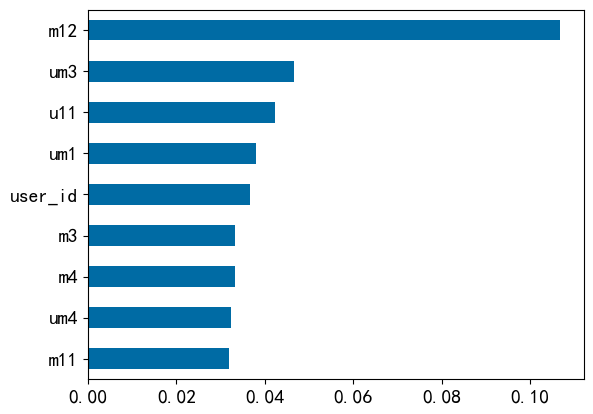

In [74]:
# top10 features
features = pd.Series(model.feature_importances_, index=train_x.columns).sort_values()
features[-9:].plot.barh()

重要性排名前三的特性为：商家用户复购率，用户购买点击比和用户-商家交互过的商品数。

In [75]:
# 进行预测
prob_rf = model.predict_proba(test)[:,1]

#### 3.4 LightGBM

In [76]:
from lightgbm import LGBMClassifier

In [77]:
# 使用默认参数建模
model = LGBMClassifier()
model.fit(train_x, train_y)

LGBMClassifier()

In [78]:
# 模型验证
auc_lgbm = roc_auc_score(valid_y, model.predict_proba(valid_x)[:,1])
print('accuracy: ', model.score(valid_x, valid_y))
print('roc_auc: ', auc_lgbm)

accuracy:  0.9373622371724839
roc_auc:  0.6825032253437361


In [79]:
# 调参
model = LGBMClassifier()
params = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 1000],
    'num_leaves': [30, 100, 500],
    'max_depth': [10, 50, 100],
    'subsample': [0.5],
    'min_split_gain': [0.05]
}
grid_search = GridSearchCV(model, params, cv=3, scoring='roc_auc')

In [80]:
grid_search.fit(train_x, train_y)

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss'],
                         'learning_rate': [0.05, 0.1],
                         'max_depth': [10, 50, 100], 'min_split_gain': [0.05],
                         'n_estimators': [100, 1000],
                         'num_leaves': [30, 100, 500], 'subsample': [0.5]},
             scoring='roc_auc')

In [81]:
# 调参后的最优参数结果
display(grid_search.best_params_)
display(grid_search.best_score_)

{'boosting_type': 'dart',
 'learning_rate': 0.05,
 'max_depth': 50,
 'min_split_gain': 0.05,
 'n_estimators': 1000,
 'num_leaves': 30,
 'subsample': 0.5}

0.68271204897605

In [82]:
# 模型验证

# 二次计算时，直接使用最优参数建模
model = LGBMClassifier(
    boosting_type='dart', 
    learning_rate=0.05,
    max_depth=10,
    min_split_gain=0.05,
    n_estimators=1000,
    num_leaves=30,
    subsample=0.5
)
model.fit(train_x, train_y)

LGBMClassifier(boosting_type='dart', learning_rate=0.05, max_depth=10,
               min_split_gain=0.05, n_estimators=1000, num_leaves=30,
               subsample=0.5)

In [83]:
auc_lgbm = roc_auc_score(valid_y, model.predict_proba(valid_x)[:,1])
print('accuracy: ', model.score(valid_x, valid_y))
print('roc_auc: ', auc_lgbm)

accuracy:  0.9374197381787515
roc_auc:  0.6866341958419876


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

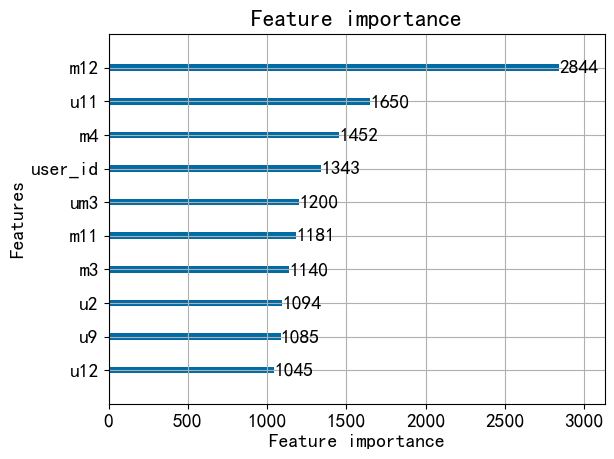

In [84]:
# top10 features
import lightgbm
lightgbm.plot_importance(model, max_num_features=10)

重要性排名前三的特性为：商家用户复购率，用户购买点击比和商家被交互过的品类数。


In [85]:
# 进行预测
prob_lgbm = model.predict_proba(test)[:,1]

#### 3.5 XGBoost

In [86]:
from xgboost import XGBClassifier

In [87]:
# 使用默认参数建模
model = XGBClassifier()
model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [88]:
# 模型评估
auc_xgb = roc_auc_score(valid_y, model.predict_proba(valid_x)[:,1])
print('accuracy: ', model.score(valid_x, valid_y))
print('roc_auc: ', auc_xgb)

accuracy:  0.936902229122343
roc_auc:  0.6726080277762269


In [89]:
# 调参
model = XGBClassifier()
params = {
    'eta': [0.05, 0.1],
    'gamma': [5, 50, 200],
    'min_child_weight': [10, 100, 1000],
    'max_depth': [5, 50, 100],
    'subsample': [0.5],
    'objective': ['binary:logistic'],
    'eval_metric': ['auc']
}
grid_search = GridSearchCV(model, params, cv=3, scoring='roc_auc')

In [90]:
grid_search.fit(train_x, train_y)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.05, 0.1], 'eval_metric': ['auc'],
                         'gamma': [5, 50, 200], 'max_depth': [5, 50, 100],
                         'min_child_weight': [10, 100, 1000],
                         'objective': ['binary:logistic'], 'subsample': [0.5]},
             scoring='roc_auc')

In [91]:
# 调参后的最优参数结果
display(grid_search.best_params_)
display(grid_search.best_score_)

{'eta': 0.1,
 'eval_metric': 'auc',
 'gamma': 5,
 'max_depth': 50,
 'min_child_weight': 100,
 'objective': 'binary:logistic',
 'subsample': 0.5}

0.6795044806939886

In [92]:
# 模型验证

# 二次计算时，直接使用最优参数建模
model = XGBClassifier(
    eta=0.1,
    gamma=5,
    max_depth=50,
    min_child_weight=100,
    objective='binary:logistic',
    eval_metric='auc',
    subsample=0.5
)
model.fit(train_x, train_y)

auc_xgb = roc_auc_score(valid_y, model.predict_proba(valid_x)[:,1])
print('accuracy: ', model.score(valid_x, valid_y))
print('roc_auc: ', auc_xgb)

accuracy:  0.9374580721829299
roc_auc:  0.6853738867591666


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

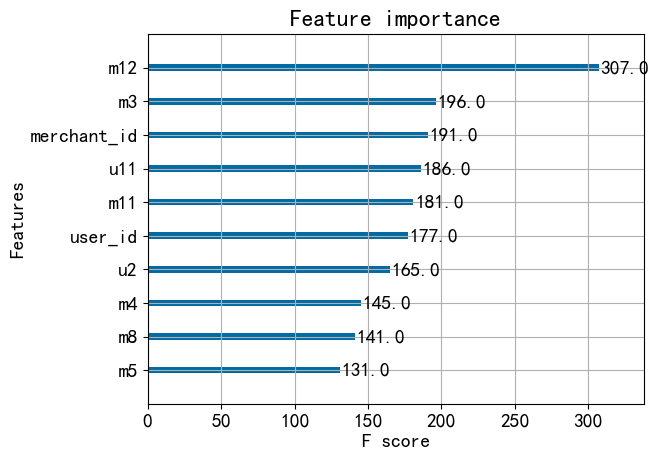

In [93]:
# top10 features
import xgboost
xgboost.plot_importance(model, max_num_features=10)

重要性排名前三的特性为：商家用户复购率，用户购买点击比和商家购买点击比

In [94]:
# 进行预测
prob_xgb = model.predict_proba(test)[:,1]

#### 3.6 比较模型结果
比较各模型结果，选取最优模型

In [95]:
# 汇总各模型分数
scores = pd.DataFrame({
    'auc': [auc_lr, auc_rf, auc_lgbm, auc_xgb],
    'model': ['LogisticRegression', 'RandomForest', 'LightGBM', 'XGBoost']
})
scores.sort_values(by='auc', ascending=False)

,auc,model
2,0.686634,LightGBM
3,0.685374,XGBoost
1,0.681618,RandomForest
0,0.665086,LogisticRegression


可以看到，模型表现最优的是LightGBM，auc分数为0.686634

In [96]:
# 保存最优模型预测结果
submission = pd.DataFrame()
submission[['user_id', 'merchant_id']] = test[['user_id', 'merchant_id']]
submission['prob'] = prob_lgbm
submission.to_csv('./data/prediction.csv', index=False)

### 4、结论
通过比较各模型auc分数，最终选取LightGBM为最优预测模型，其auc分数为0.686634，在针对各模型的特征重要性排序中，用户的购买点击比、商家的用户复购率这两个特性在各模型中都排在前列，对模型的影响最大。